# Performance Tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

from interactive_index import InteractiveIndex

## Load LVIS Embeddings

In [3]:
embeddings = np.load("lvis-embeddings.npy", allow_pickle=True).item()
image_fnames = list(embeddings.keys())
res1024_embs = np.array([embeddings[img]['res4'] for img in image_fnames]).squeeze()
res2048_embs = np.array([embeddings[img]['res5'] for img in image_fnames]).squeeze()

assert res1024_embs.shape == (len(image_fnames), 1024)
assert res2048_embs.shape == (len(image_fnames), 2048)

## Create Two Indexes

We're going to need to be creating these indexes a lot, so let's write a convenience function for it.

In [4]:
def create_indexes(d0=1024, d1=2048, n_centroids=512, vectors_per_index=len(image_fnames) // 8):
    index0 = InteractiveIndex(
        d=d0, n_centroids=n_centroids, vectors_per_index=vectors_per_index, tempdir='/tmp/idx0'
    )
    
    index1 = InteractiveIndex(
        d=d1, n_centroids=n_centroids, vectors_per_index=vectors_per_index, tempdir='/tmp/idx1'
    )
    
    return index0, index1

## Speedup vs. Accuracy Varying Number of Probes

In [12]:
index_1024, index_2048 = create_indexes()

### Train the indexes

In [13]:
n_train = 20_000
start = time.time()
index_1024.train(res1024_embs[:n_train])
end = time.time()
print(f'Training index_1024 on {n_train} vectors for {index_1024.n_centroids} clusters took {end - start:.3} seconds')

start = time.time()
index_2048.train(res2048_embs[:n_train])
end = time.time()
print(f'Training index_2048 on {n_train} vectors for {index_2048.n_centroids} clusters took {end - start:.3} seconds')

Training index_1024 on 20000 vectors for 512 clusters took 0.945 seconds
Training index_2048 on 20000 vectors for 512 clusters took 1.65 seconds


## Add all vectors

To be within the memory space of our gpu, let's add in batches of vectors_per_index.

In [14]:
inc = 2 * index_1024.vectors_per_index

for i in range(len(image_fnames) // inc):
    start = time.time()
    index_1024.add(res1024_embs[i * inc:(i + 1) * inc])
    end = time.time()
    print(f'Adding {inc}, 1024-D vectors to index_1024 with {index_1024.n_centroids} clusters took {end - start:.3} seconds')

for i in range(len(image_fnames) // inc):
    start = time.time()
    index_2048.add(res2048_embs[i * inc:(i + 1) * inc])
    end = time.time()
    print(f'Adding {inc}, 2048-D vectors to index_2048 with {index_2048.n_centroids} clusters took {end - start:.3} seconds')

Adding 40922, 1024-D vectors to index_1024 with 512 clusters took 1.64 seconds
Adding 40922, 1024-D vectors to index_1024 with 512 clusters took 1.52 seconds
Adding 40922, 1024-D vectors to index_1024 with 512 clusters took 1.54 seconds
Adding 40922, 1024-D vectors to index_1024 with 512 clusters took 1.54 seconds
Adding 40922, 2048-D vectors to index_2048 with 512 clusters took 2.82 seconds
Adding 40922, 2048-D vectors to index_2048 with 512 clusters took 2.83 seconds
Adding 40922, 2048-D vectors to index_2048 with 512 clusters took 2.82 seconds
Adding 40922, 2048-D vectors to index_2048 with 512 clusters took 2.83 seconds


In [16]:
# merge the partial indexes before searching
start = time.time()
index_1024.merge_partial_indexes()
end = time.time()
print(f'd=1024: Merging {index_1024.n_indexes} partial indexes with {index_1024.n_vectors} vectors took {end - start:.3} seconds')

start = time.time()
index_2048.merge_partial_indexes()
end = time.time()
print(f'd=2048: Merging {index_2048.n_indexes} partial indexes with {index_2048.n_vectors} vectors took {end - start:.3} seconds')


d=1024: Merging 8 partial indexes with 163688 vectors took 0.367 seconds
d=2048: Merging 8 partial indexes with 163688 vectors took 1.03 seconds


## Get Ground-Truth for Accuracy

Since all the vectors are stored in full for these indexes, we can get the precise nearest neighbors by setting `n_probes` to the number of clusters.

In [15]:
# Pick 50 random embeddings
n_xq = 50
xq_1024 = res1024_embs[np.random.choice(np.arange(res1024_embs.shape[0]), n_xq)]
xq_2048 = res2048_embs[np.random.choice(np.arange(res2048_embs.shape[0]), n_xq)]

In [23]:
# Get the 100 nearest neighbors
k = 100

start = time.time()
dists_1024, inds_1024 = index_1024.query(xq_1024, k=k, n_probes=index_1024.n_centroids)
end = time.time()
print(f'd=1024: Querying the {k} nearest neighbors of {n_xq} points across all centroids took {end - start:.3} seconds')

start = time.time()
dists_2048, inds_2048 = index_2048.query(xq_2048, k=k, n_probes=index_2048.n_centroids)
end = time.time()
print(f'd=2048: Querying the {k} nearest neighbors of {n_xq} points across all centroids took {end - start:.3} seconds')


d=1024: Querying the 100 nearest neighbors of 50 points across all centroids took 9.87 seconds
d=2048: Querying the 100 nearest neighbors of 50 points across all centroids took 19.0 seconds


In [29]:
max_n_probes = index_1024.n_centroids

times_1024 = np.empty(max_n_probes//4)
avg_recall_pct_1024 = np.empty(max_n_probes//4)
avg_dist_1024 = np.empty(max_n_probes//4)

for n_probes in range(max_n_probes, 0, -4):
    start = time.time()
    dists, inds = index_1024.query(xq_1024, k=k, n_probes=n_probes)
    end = time.time()
    print(f'n_probes={n_probes}: {end-start:.3} seconds')
    
    times_1024[n_probes//4 - 1] = end - start
    avg_dist_1024[n_probes//4 - 1] = dists.mean()
    
    recall_pcts = 0
    for i in range(len(inds)):
        recall_pcts += len(set(inds[i]) & set(inds_1024[i])) / k
    
    avg_recall_pct_1024[n_probes//4 - 1] = recall_pcts / len(inds)


n_probes=512: 9.82 seconds
n_probes=508: 10.0 seconds
n_probes=504: 9.96 seconds
n_probes=500: 9.89 seconds
n_probes=496: 10.0 seconds
n_probes=492: 9.9 seconds
n_probes=488: 9.88 seconds
n_probes=484: 9.8 seconds
n_probes=480: 9.9 seconds
n_probes=476: 9.74 seconds
n_probes=472: 9.77 seconds
n_probes=468: 9.82 seconds
n_probes=464: 9.8 seconds
n_probes=460: 9.74 seconds
n_probes=456: 9.63 seconds
n_probes=452: 9.62 seconds
n_probes=448: 9.61 seconds
n_probes=444: 9.57 seconds
n_probes=440: 9.58 seconds
n_probes=436: 9.4 seconds
n_probes=432: 9.41 seconds
n_probes=428: 9.39 seconds
n_probes=424: 9.38 seconds
n_probes=420: 9.19 seconds
n_probes=416: 9.18 seconds
n_probes=412: 9.18 seconds
n_probes=408: 9.08 seconds
n_probes=404: 9.0 seconds
n_probes=400: 9.04 seconds
n_probes=396: 9.04 seconds
n_probes=392: 8.87 seconds
n_probes=388: 8.91 seconds
n_probes=384: 8.91 seconds
n_probes=380: 8.69 seconds
n_probes=376: 8.76 seconds
n_probes=372: 8.53 seconds
n_probes=368: 8.58 seconds
n_probe

In [30]:
max_n_probes = index_2048.n_centroids

times_2048 = np.empty(max_n_probes//4)
avg_recall_pct_2048 = np.empty(max_n_probes//4)
avg_dist_2048 = np.empty(max_n_probes//4)

for n_probes in range(max_n_probes, 0, -4):
    start = time.time()
    dists, inds = index_2048.query(xq_2048, k=k, n_probes=n_probes)
    end = time.time()
    print(f'n_probes={n_probes}: {end-start:.3} seconds')
    
    times_2048[n_probes//4 - 1] = end - start
    avg_dist_2048[n_probes//4 - 1] = dists.mean()
    
    recall_pcts = 0
    for i in range(len(inds)):
        recall_pcts += len(set(inds[i]) & set(inds_2048[i])) / k
    
    avg_recall_pct_2048[n_probes//4 - 1] = recall_pcts / len(inds)


n_probes=512: 19.7 seconds
n_probes=508: 19.8 seconds
n_probes=504: 19.7 seconds
n_probes=500: 19.5 seconds
n_probes=496: 19.6 seconds
n_probes=492: 19.7 seconds
n_probes=488: 19.7 seconds
n_probes=484: 19.3 seconds
n_probes=480: 19.5 seconds
n_probes=476: 19.5 seconds
n_probes=472: 19.2 seconds
n_probes=468: 19.3 seconds
n_probes=464: 19.2 seconds
n_probes=460: 19.0 seconds
n_probes=456: 19.1 seconds
n_probes=452: 18.8 seconds
n_probes=448: 18.8 seconds
n_probes=444: 18.6 seconds
n_probes=440: 18.8 seconds
n_probes=436: 18.7 seconds
n_probes=432: 18.7 seconds
n_probes=428: 18.6 seconds
n_probes=424: 18.6 seconds
n_probes=420: 18.2 seconds
n_probes=416: 18.1 seconds
n_probes=412: 18.3 seconds
n_probes=408: 17.9 seconds
n_probes=404: 17.7 seconds
n_probes=400: 17.7 seconds
n_probes=396: 17.6 seconds
n_probes=392: 17.8 seconds
n_probes=388: 17.6 seconds
n_probes=384: 17.6 seconds
n_probes=380: 17.4 seconds
n_probes=376: 17.3 seconds
n_probes=372: 17.1 seconds
n_probes=368: 17.1 seconds
n

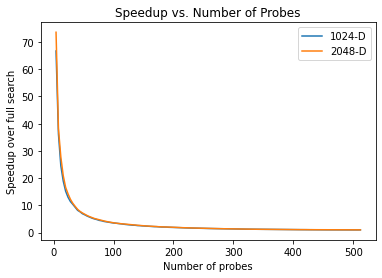

In [49]:
plt.plot((np.arange(len(times_1024)) + 1) * 4, times_1024[-1] / times_1024, label='1024-D')
plt.plot((np.arange(len(times_2048)) + 1) * 4, times_2048[-1] / times_2048, label='2048-D')
plt.legend()
plt.ylabel('Speedup over full search')
plt.xlabel('Number of probes')
plt.title('Speedup vs. Number of Probes')
plt.show()

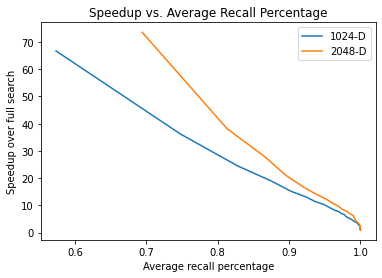

In [45]:
plt.plot(avg_recall_pct_1024, times_1024[-1] / times_1024, label='1024-D')
plt.plot(avg_recall_pct_2048, times_2048[-1] / times_2048, label='2048-D')
plt.legend()
plt.ylabel('Speedup over full search')
plt.xlabel('Average recall percentage')
plt.title('Speedup vs. Average Recall Percentage')
plt.show()

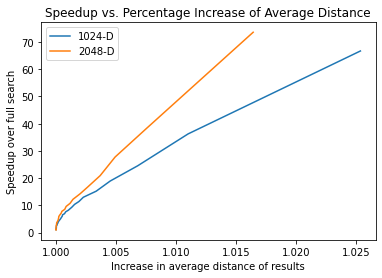

In [46]:
plt.plot(np.sqrt(avg_dist_1024 / avg_dist_1024[-1]), times_1024[-1] / times_1024, label='1024-D')
plt.plot(np.sqrt(avg_dist_2048 / avg_dist_2048[-1]), times_2048[-1] / times_2048, label='2048-D')
plt.legend()
plt.ylabel('Speedup over full search')
plt.xlabel('Increase in average distance of results')
plt.title('Speedup vs. Percentage Increase of Average Distance')
plt.show()

In [57]:
start = time.time()
dists, inds = index_1024.query(xq_1024[0], k=100, n_probes=512)
end = time.time()
print(end-start)


0.3320941925048828
